# To Grant or Not to Grant: Deciding on Compensation Benefits 

### Machine Learning Group Project 2024/2025 - Group 52


__Members:__
- Diogo Rodrigues _(20240512@novaims.unl.pt)_
- Alexandre Gonçalves _(20240738@novaims.unl.pt)_
- Pedro Costa _(20222121@novaims.unl.pt)_
- Santiago Taylor _(20240542@novaims.unl.pt)_
- Lena Hermann _(20241446@novaims.unl.pt)_

## Introduction
- __Motivation__: x
- __Dataset__: The dataset represents claims from the start of 2020 till the end of 2022 (training data) and from January 2023 onward (test data). A detailed description of the columns of the datasets can be found below.
- __Task and Goal__: The purpose of this notebook is to create and evaluate several classification models for accurately predicting the WCB’s final decision on what type of injury should be given to a claim.

| **ATTRIBUTE**                        | **DESCRIPTION**                                                                                                         |
|--------------------------------------|-------------------------------------------------------------------------------------------------------------------------|
| Accident Date                        | Injury date of the claim.                                                                                               |
| Age at Injury                        | Age of injured worker when the injury occurred.                                                                         |
| Alternative Dispute Resolution       | Adjudication processes external to the Board.                                                                           |
| Assembly Date                        | The date the claim was first assembled.                                                                                 |
| Attorney/Representative              | Is the claim being represented by an Attorney?                                                                          |
| Average Weekly Wage                  | The wage used to calculate workers’ compensation, disability, or Paid Leave wage replacement benefits.                  |
| Birth Year                           | The reported year of birth of the injured worker.                                                                       |
| C-2 Date                             | Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2).              |
| C-3 Date                             | Date Form C-3 (Employee Claim Form) was received.                                                                       |
| Carrier Name                         | Name of primary insurance provider responsible for providing workers’ compensation coverage to the injured worker's employer. |
| Carrier Type                         | Type of primary insurance provider responsible for providing workers’ compensation coverage.                            |
| Claim Identifier                     | Unique identifier for each claim, assigned by WCB.                                                                      |
| County of Injury                     | Name of the New York County where the injury occurred.                                                                  |
| COVID-19 Indicator                   | Indication that the claim may be associated with COVID-19.                                                              |
| District Name                        | Name of the WCB district office that oversees claims for that region or area of the state.                              |
| First Hearing Date                   | Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held. |
| Gender                               | The reported gender of the injured worker.                                                                              |
| IME-4 Count                          | Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner’s Report of Independent Medical Examination” form. |
| Industry Code                        | NAICS code and descriptions are available at https://www.naics.com/search-naics-codes-by-industry/.                     |
| Industry Code Description            | 2-digit NAICS industry code description used to classify businesses according to their economic activity.               |
| Medical Fee Region                   | Approximate region where the injured worker would receive medical service.                                               |
| OIICS Nature of Injury Description   | The OIICS nature of injury codes & descriptions are available at https://www.bls.gov/iif/oiics_manual_2007.pdf.         |
| WCIO Cause of Injury Code            | The WCIO cause of injury codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Cause_Table.pdf.  |
| WCIO Cause of Injury Description     | See description of field above.                                                                                         |
| WCIO Nature of Injury Code           | The WCIO nature of injury are available at https://www.wcio.org/Active%20PNC/WCIO_Nature_Table.pdf.                     |
| WCIO Nature of Injury Description    | See description of field above.                                                                                         |
| WCIO Part Of Body Code               | The WCIO part of body codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf.      |
| WCIO Part Of Body Description        | See description of field above.                                                                                         |
| Zip Code                             | The reported ZIP code of the injured worker’s home address.                                                             |
| Agreement Reached                    | Binary variable: Yes if there is an agreement without the involvement of the WCB -> unknown at the start of a claim.    |
| WCB Decision                         | Multiclass variable: Decision of the WCB relative to the claim: “Accident” means that claim refers to workplace accident, “Occupational Disease” means illness from the workplace. -> requires WCB deliberation so it is unknown at start of claim. |
| Claim Injury Type                    | Main target variable: Deliberation of the WCB relative to benefits awarded to the claim. Numbering indicates severity.   |


## Table of Content
<a id='top'></a>
[1. Set-Up and Data Loading](#dataload) <br>
[2. Data Understanding and Exploration](#dataunderstand) <br>
[3. Data Cleaning and Pre-processing](#dataclean) <br>
[4. Feature Selection](#features) <br>
[5. Modeling and Evaluation](#modeling) <br>

## 1. Set-Up and Data Loading <a id='dataload'></a>
[to the top](#top)

### 1.1 Import the needed libraries

In [91]:
import numpy as np #to efficiently compute functions
import pandas as pd #to work with data frames
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile #to open zipfile

# data partition
from sklearn.model_selection import train_test_split

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE


# embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

### 1.2 Read the data and first overview

In [92]:
train_zip_path = 'train_data.csv.zip'
test_zip_path = 'test_data.csv.zip'

# open csv file from zip
def read_zipped_csv(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        csv_filename = z.namelist()[0]
        
        with z.open(csv_filename) as f:
            return pd.read_csv(f)

train_df = read_zipped_csv(train_zip_path)
test_df = read_zipped_csv(test_zip_path)

print("Train Data:")
print(train_df.head())
print("\nTest Data:")
print(test_df.head())

Train Data:
  Accident Date  Age at Injury Alternative Dispute Resolution Assembly Date  \
0    2019-12-30           31.0                              N    2020-01-01   
1    2019-08-30           46.0                              N    2020-01-01   
2    2019-12-06           40.0                              N    2020-01-01   
3           NaN            NaN                            NaN    2020-01-01   
4    2019-12-30           61.0                              N    2020-01-01   

  Attorney/Representative  Average Weekly Wage  Birth Year    C-2 Date  \
0                       N                 0.00      1988.0  2019-12-31   
1                       Y              1745.93      1973.0  2020-01-01   
2                       N              1434.80      1979.0  2020-01-01   
3                     NaN                  NaN         NaN         NaN   
4                       N                  NaN      1958.0  2019-12-31   

     C-3 Date                  Carrier Name  ... WCIO Cause of Injur

In [93]:
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


## 2. Data Understanding and Exploration <a id='dataunderstand'></a>
[to the top](#top)

In [94]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [95]:
# Have a first look at the numerical variables and their distirbutions
train_df.describe()

,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
count,574026.000000,5.453750e+05,544948.000000,5.934710e+05,132803.000000,564068.000000,0.0,558386.000000,558369.000000,556944.000000,574026.000000,574026.000000
mean,42.114270,4.910883e+02,1886.767604,2.366760e+07,3.207337,58.645305,NaN,54.381143,41.013839,39.738146,0.046665,3.006559
std,14.256432,6.092918e+03,414.644423,1.079271e+08,2.832303,19.644175,NaN,25.874281,22.207521,22.365940,0.210921,2.000801
min,0.000000,0.000000e+00,0.000000,5.393066e+06,1.000000,11.000000,NaN,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,31.000000,0.000000e+00,1965.000000,5.593414e+06,1.000000,45.000000,NaN,31.000000,16.000000,33.000000,0.000000,1.000000
50%,42.000000,0.000000e+00,1977.000000,5.791212e+06,2.000000,61.000000,NaN,56.000000,49.000000,38.000000,0.000000,3.000000
75%,54.000000,8.410000e+02,1989.000000,5.991000e+06,4.000000,71.000000,NaN,75.000000,52.000000,53.000000,0.000000,5.000000
max,117.000000,2.828079e+06,2018.000000,9.998917e+08,73.000000,92.000000,NaN,99.000000,91.000000,99.000000,1.000000,6.000000


In [96]:
# Have a first look at the categorical variables and their distirbutions
train_df.describe(include='O')

,Accident Date,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,...,District Name,First Hearing Date,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,570337,574026,593471,574026,559466,187245,574026,574026,574026,574026,...,574026,150798,574026,564068,574026,558386,558369,556944,545389,574026
unique,5539,3,1096,2,2475,1648,2046,8,8,63,...,8,1094,4,20,5,74,56,54,10060,1
top,2020-03-01,N,2020-03-06,N,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,...,NYC,2022-04-15,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,1245,571412,1422,392291,1847,350,111144,285368,291078,60430,...,270779,440,335218,114339,265981,46610,153373,51862,3302,574026


In [97]:
# before working on the dataset, we will do a copy so we can use the original one if we need it
train_df_temp = train_df.copy()

__Target Variable__

We just have a look at the distribution of the target variable 'Claim Injury Type'. To check how our dataset is balanced.

In [98]:
train_df_temp['Claim Injury Type'].value_counts()

2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: Claim Injury Type, dtype: int64

In [99]:
non_comp_percent = round(train_df_temp['Claim Injury Type'].value_counts().max() / len(train_df_temp),4)

print('Percentage of Non-Comp Cases: {}%'.format(non_comp_percent*100))

Percentage of Non-Comp Cases: 49.05%


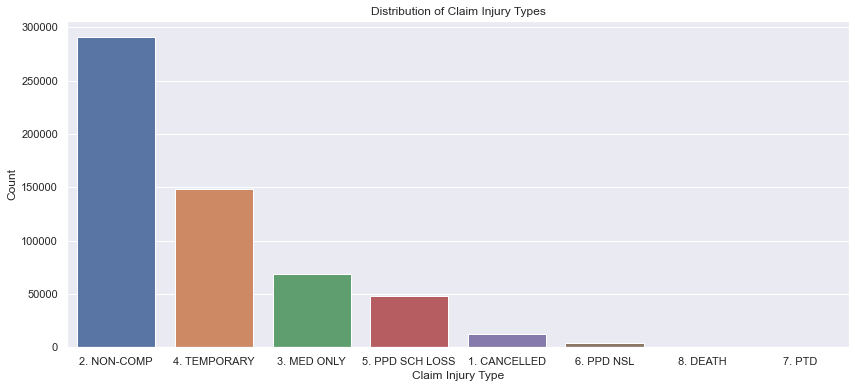

In [100]:
# Plot distribution of target values
target_values = train_df_temp['Claim Injury Type'].value_counts()

df_target_counts = target_values.reset_index()
df_target_counts.columns = ['Claim Injury Type', 'Count']

plt.figure(figsize=(14, 6))
sns.barplot(x='Claim Injury Type', y='Count', data=df_target_counts)
#plt.xticks(rotation=45)
plt.title('Distribution of Claim Injury Types')
plt.show()

We can see that we have 7 different classes. One class, "NON-COMP", is very dominantly present with making up for 49.05% of the cases.

Let's have an initial look at the correlation of the target variable with the other features.

In [101]:
# Since 'Claim Injury Type' is categorical, let's convert it to numeric to check for the correlation
train_df_temp['Claim Injury Type Numeric'] = train_df_temp['Claim Injury Type'].astype('category').cat.codes

In [177]:
corr_base = train_df_temp.corr()
corr_base

,Age at Injury,Average Weekly Wage,Claim Identifier,IME-4 Count,OIICS Nature of Injury Description,Agreement Reached,Number of Dependents,Claim Injury Type Numeric
Age at Injury,1.000000,0.016196,-0.010944,0.067650,NaN,0.019079,0.000461,0.126114
Average Weekly Wage,0.016196,1.000000,-0.003451,-0.008122,NaN,0.005610,-0.001098,0.091868
Claim Identifier,-0.010944,-0.003451,1.000000,-0.112271,NaN,-0.077430,0.001610,-0.380843
IME-4 Count,0.067650,-0.008122,-0.112271,1.000000,NaN,0.090987,0.000046,0.031527
OIICS Nature of Injury Description,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Agreement Reached,0.019079,0.005610,-0.077430,0.090987,NaN,1.000000,-0.000189,0.225043
Number of Dependents,0.000461,-0.001098,0.001610,0.000046,NaN,-0.000189,1.000000,-0.000464
Claim Injury Type Numeric,0.126114,0.091868,-0.380843,0.031527,NaN,0.225043,-0.000464,1.000000


So lets have a look at the features itself.

__Age at Injury__

In [103]:
train_df_temp['Age at Injury'].describe()

count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64

We can already see that the minimum and maximum values seem kind of strang with ranging from 0 to 117. We will deal with them in the outlier section.

In [104]:
# plot the distribution of a single feature with respect to the target categorical variable.
def feature_distribution(data, feature, target_variable):
    plt.figure(figsize=(13, 8))
    sns.histplot(data=data, x=feature, hue=target_variable, multiple="stack")
    plt.title(f'Distribution of {feature}', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()


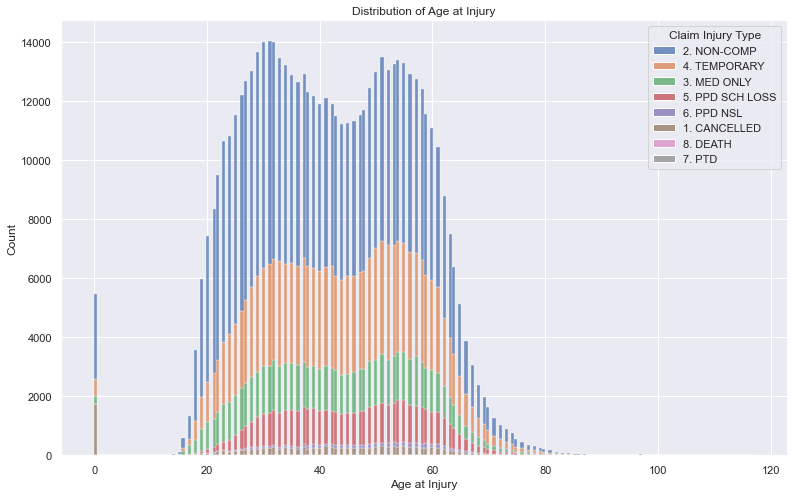

In [105]:
feature_distribution(train_df_temp, 'Age at Injury', 'Claim Injury Type')

Some difference of the claim injury type related to the age can already be seen.

__Birth Year__

This variable results from accident date and age at accident. Therefore, we do not need it as it does not add any new information.

In [106]:
train_df_temp = train_df_temp.drop(columns='Birth Year')

In [107]:
# include the other variables !

__Code and Description Variables__

For the Industry Code & Industry Code Description variables, as well as for the WCIO variables, we want to check their relationship.

In [108]:
def analyze_code_description_relationship(data, code_column, description_column):
    # Step 1: Count unique descriptions per code
    code_to_description = data.groupby(code_column)[description_column].nunique()
    # Check if each code maps to a single unique description
    if code_to_description.max() == 1:
        print(f"\nEach {code_column} has only one unique {description_column}.")
    else:
        print(f"\nSome {code_column}s have multiple {description_column}s associated with them.")

    # Step 2: Count unique codes per description
    description_to_code = data.groupby(description_column)[code_column].nunique()
    # Check if each description maps to a single unique code
    if description_to_code.max() == 1:
        print(f"\nEach {description_column} has only one unique {code_column}.")
    else:
        print(f"\nSome {description_column}s have multiple {code_column}s associated with them.")

    # Step 3: Validate if there is a 1:1 relationship
    is_one_to_one = (code_to_description.max() == 1) and (description_to_code.max() == 1)
    if is_one_to_one:
        print(f"\n{code_column} and {description_column} have a 1:1 relationship.")
    else:
        print(f"\nThere is no 1:1 relationship between {code_column} and {description_column}.")

    # Step 4: Find descriptions with multiple unique associated codes
    description_to_unique_codes = data.groupby(description_column)[code_column].apply(lambda x: list(set(x)))
    descriptions_with_multiple_unique_codes = description_to_unique_codes[description_to_unique_codes.apply(len) > 1]
    
    print(f"\nDescriptions with multiple unique associated {code_column}s:")
    print(descriptions_with_multiple_unique_codes)

__Industry Code / Industry Code Description__

In [109]:
analyze_code_description_relationship(train_df_temp, 'Industry Code', 'Industry Code Description')


Each Industry Code has only one unique Industry Code Description.

Some Industry Code Descriptions have multiple Industry Codes associated with them.

There is no 1:1 relationship between Industry Code and Industry Code Description.

Descriptions with multiple unique associated Industry Codes:
Industry Code Description
MANUFACTURING                     [32.0, 33.0, 31.0]
RETAIL TRADE                            [44.0, 45.0]
TRANSPORTATION AND WAREHOUSING          [48.0, 49.0]
Name: Industry Code, dtype: object


For each __Industry Code__, the first check shows that each code corresponds to only one unique description. This indicates that every industry code maps to a single description.

However, the second check reveals that some __Industry Code Descriptions__ map to more than one Industry Code. Specifically, the description "MANUFACTURING" maps to 3 different codes, and "RETAIL TRADE" and "TRANSPORTATION AND WAREHOUSING" each map to 2 different codes.

Since each Industry Code uniquely maps to one Industry Code Description, we can delete the Industry Code and only keep its corresponding description. We will keep the description variable because we have more information within it that we will use for binning / mapping later. Since we have almost the same withformation in both variables, we don't need to keep both since it would distort the data for the models.

In [110]:
train_df_temp = train_df_temp.drop(columns='Industry Code')

__WCIO Cause of Injury Code / WCIO Cause of Injury Description__

In [111]:
analyze_code_description_relationship(train_df_temp, 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description')


Each WCIO Cause of Injury Code has only one unique WCIO Cause of Injury Description.

Some WCIO Cause of Injury Descriptions have multiple WCIO Cause of Injury Codes associated with them.

There is no 1:1 relationship between WCIO Cause of Injury Code and WCIO Cause of Injury Description.

Descriptions with multiple unique associated WCIO Cause of Injury Codes:
WCIO Cause of Injury Description
OBJECT BEING LIFTED OR HANDLED    [17.0, 66.0, 79.0]
REPETITIVE MOTION                       [97.0, 94.0]
Name: WCIO Cause of Injury Code, dtype: object


For __WCIO Cause of Injury Code / Description__ it is the same as for __Industry Code / Description__. It shows that each code corresponds to only one unique description. This indicates that every code maps to a single description. However, some __WCIO Cause of Injury Descriptions__ map to more than one WCIO Cause of Injury Code. We will also just keep the __WCIO Cause of Injury Description.__

In [112]:
train_df_temp = train_df_temp.drop(columns='WCIO Cause of Injury Code')

__WCIO Nature of Injury Code / WCIO Nature of Injury Description__

In [113]:
analyze_code_description_relationship(train_df_temp, 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description')


Each WCIO Nature of Injury Code has only one unique WCIO Nature of Injury Description.

Each WCIO Nature of Injury Description has only one unique WCIO Nature of Injury Code.

WCIO Nature of Injury Code and WCIO Nature of Injury Description have a 1:1 relationship.

Descriptions with multiple unique associated WCIO Nature of Injury Codes:
Series([], Name: WCIO Nature of Injury Code, dtype: object)


Since the Code and the Description have a 1:1 relationship, we will delete __WCIO Nature of Injury Code__. We decided to keep the description insted of the code to later map into groups. This can be done better with the descriptions than the code because we have more information in the descriptions.

In [114]:
train_df_temp = train_df_temp.drop(columns='WCIO Nature of Injury Code')

__WCIO Part Of Body Code / WCIO Part Of Body Description__

In [115]:
analyze_code_description_relationship(train_df_temp, 'WCIO Part Of Body Code', 'WCIO Part Of Body Description')


Each WCIO Part Of Body Code has only one unique WCIO Part Of Body Description.

Some WCIO Part Of Body Descriptions have multiple WCIO Part Of Body Codes associated with them.

There is no 1:1 relationship between WCIO Part Of Body Code and WCIO Part Of Body Description.

Descriptions with multiple unique associated WCIO Part Of Body Codes:
WCIO Part Of Body Description
DISC           [43.0, 22.0]
SOFT TISSUE    [25.0, 18.0]
SPINAL CORD    [47.0, 23.0]
Name: WCIO Part Of Body Code, dtype: object


For __WCIO Part Of Body Code / Description__ it is the same as for __Industry Code / Description__ and __WCIO Cause of Injury Code / Description__. It shows that each code corresponds to only one unique description. We will also just keep the __WCIO Part Of Body Description__ for further mapping reasons.

In [116]:
train_df_temp = train_df_temp.drop(columns='WCIO Part Of Body Code')

## 3. Data Cleaning and Pre-processing <a id='dataclean'></a>
[to the top](#top)

### 3.1 Missing Values

In [117]:
# Calculation of the number and percentage of missing values per column
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values = missing_values_table(train_df_temp)

Your selected dataframe has 29 columns.
There are 26 columns that have missing values.


In [118]:
missing_values

,Missing Values,% of Total Values
OIICS Nature of Injury Description,593471,100.0
IME-4 Count,460668,77.6
First Hearing Date,442673,74.6
C-3 Date,406226,68.4
Average Weekly Wage,48096,8.1
Zip Code,48082,8.1
WCIO Part Of Body Description,36527,6.2
WCIO Nature of Injury Description,35102,5.9
WCIO Cause of Injury Description,35085,5.9
C-2 Date,34005,5.7


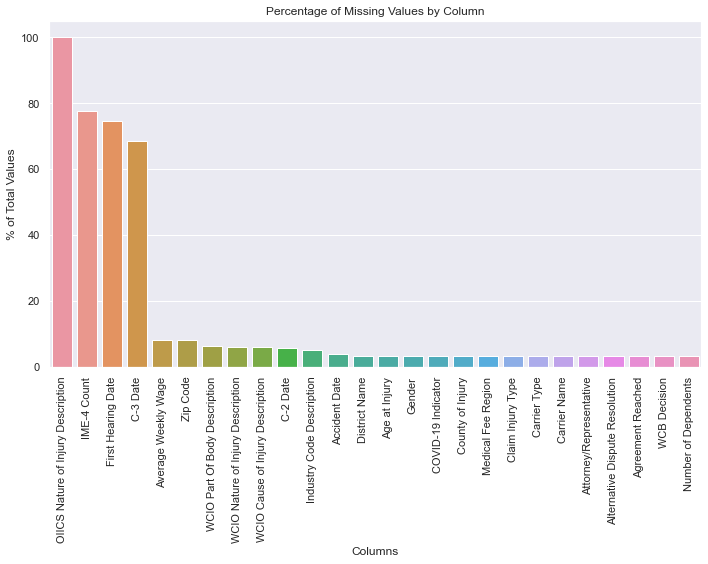

In [119]:
# Assuming mis_val_table_ren_columns is your resulting table
def plot_missing_values(mis_val_table):
    plt.figure(figsize=(10, 8))
    
    # Create a bar plot for the percentage of missing values
    sns.barplot(x=mis_val_table.index, 
                y=mis_val_table['% of Total Values'])
    
    # Rotate the x labels for better readability
    plt.xticks(rotation=90)
    
    # Set plot labels and title
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Columns')
    plt.ylabel('% of Total Values')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the missing values
plot_missing_values(missing_values)

The first look at the missing values reveals four insights:
1. There exist __only two__ variables __without missing values__ (Assembly Date and Claim Identifier)
2. There exists __one__ variable with __only missing values__ (OIICS Nature of Injury Description). This variable will be dropped directly.
3. There exist __three__ variables with missing values ranging from __68% - 78%__, which might be dropped.
4. Several variabes show the __same amount of missing values__ (3.28% and 5.91%)
5. Our target variable __"Claim Injury Type"__ has __19445 missing values__. The respective rows can be dropped because imputation of the target variable introduces artificial outcomes, creating bias and compromising the integrity of our model.

In [120]:
# Copy of data for preprocessing
train_df_prep = train_df_temp.copy()

# Drop the variable with only missing values
train_df_prep = train_df_prep.drop(columns='OIICS Nature of Injury Description')

In [121]:
# Drop rows where the target variable is missing
train_df_prep = train_df_prep.dropna(subset=['Claim Injury Type'])

# Check the shape of the cleaned DataFrame
print(f"Remaining rows after dropping missing target values: {len(train_df_prep)}")
print(f"Percentage of the whole training data set: {round(len(train_df_prep)/len(train_df),2)*100}%")


Remaining rows after dropping missing target values: 574026
Percentage of the whole training data set: 97.0%


In [122]:
missing_values_2 = missing_values_table(train_df_prep)

Your selected dataframe has 28 columns.
There are 11 columns that have missing values.


In [123]:
missing_values_2

,Missing Values,% of Total Values
IME-4 Count,441223,76.9
First Hearing Date,423228,73.7
C-3 Date,386781,67.4
Average Weekly Wage,28651,5.0
Zip Code,28637,5.0
WCIO Part Of Body Description,17082,3.0
WCIO Nature of Injury Description,15657,2.7
WCIO Cause of Injury Description,15640,2.7
C-2 Date,14560,2.5
Industry Code Description,9958,1.7


Nice! We can see that when dropping the rows with the missing target values, a lot of our features had the same missing values in these rows!

Let's have a look at the three variables with the high percentage of missing values:
- __IME-4 Count (77.62%)__: This variable describes the number of IME-4 forms received per claim. The missing values could be replaced with zeros, however, since the amout of missing values is so high, it's variance is relatively small.
- __First Hearing Date (74.59%)__: The description of the variable states that a blank date means the claim has not yet had a hearing held. The relationship between the date variables should be checked to determine if its relevant. Further, if the variable has an impact on the target variable, one idea would be to transform it into a binary variable which states if the first hearing date took place already (=1) or not (=0).
- __C-3 Date (68.45%)__: This variable means that the Date Form C-3 (Employee Claim Form) was received. It could also be transformed into a binary variable if it is important.

In [124]:
train_df_prep['IME-4 Count'].value_counts()

1.0     40112
2.0     34504
3.0     16136
4.0     13781
5.0      7680
6.0      6427
7.0      3838
8.0      3156
9.0      1915
10.0     1460
11.0     1002
12.0      807
13.0      516
14.0      396
15.0      273
16.0      214
18.0      140
17.0      125
19.0       79
20.0       56
21.0       53
22.0       34
23.0       19
24.0       16
27.0       14
26.0        8
25.0        7
29.0        5
28.0        4
30.0        4
32.0        4
34.0        4
36.0        3
33.0        2
31.0        2
39.0        2
37.0        1
48.0        1
35.0        1
47.0        1
73.0        1
Name: IME-4 Count, dtype: int64

In [125]:
# Since 'Claim Injury Type' is categorical, let's convert it to numeric to check for the correlation
train_df_prep['Claim Injury Type Numeric'] = train_df_prep['Claim Injury Type'].astype('category').cat.codes

# Calculate the correlation
correlation_value = train_df_prep[['Claim Injury Type Numeric', 'IME-4 Count']].corr().iloc[0, 1]
print(f"Correlation between IME-4 Count and Claim Injury Type: {correlation_value}")

Correlation between IME-4 Count and Claim Injury Type: 0.03152676879822572


Based on the low correlation to the target, we will drop the variable.

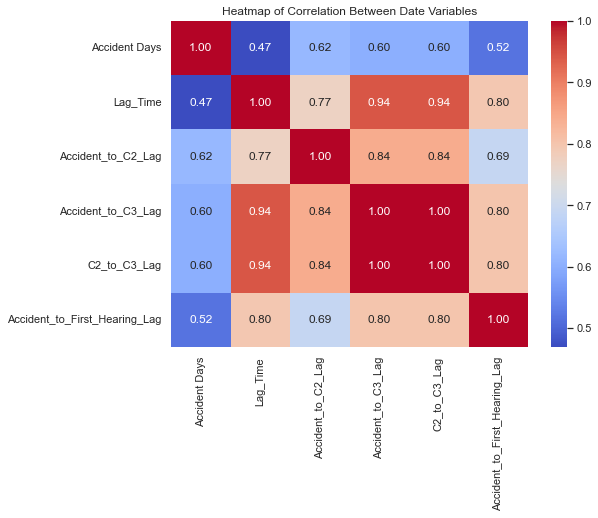

In [127]:
# Convert columns to datetime format and handle errors
train_df_date = train_df_prep.copy()
train_df_date['Accident Date'] = pd.to_datetime(train_df_date['Accident Date'], errors='coerce')
train_df_date['Assembly Date'] = pd.to_datetime(train_df_date['Assembly Date'], errors='coerce')
train_df_date['C-2 Date'] = pd.to_datetime(train_df_date['C-2 Date'], errors='coerce')
train_df_date['C-3 Date'] = pd.to_datetime(train_df_date['C-3 Date'], errors='coerce')
train_df_date['First Hearing Date'] = pd.to_datetime(train_df_date['First Hearing Date'], errors='coerce')

# Check for any correlation between date columns by converting them to numeric values (days since start)
train_df_date['Accident Days'] = (train_df_date['Accident Date'] - train_df_date['Accident Date'].min()).dt.days
train_df_date['Lag_Time'] = (train_df_date['Assembly Date'] - train_df_date['Accident Date'].min()).dt.days
train_df_date['Accident_to_C2_Lag'] = (train_df_date['C-2 Date'] - train_df_date['Accident Date'].min()).dt.days
train_df_date['Accident_to_C3_Lag'] = (train_df_date['C-3 Date'] - train_df_date['Accident Date'].min()).dt.days
train_df_date['C2_to_C3_Lag'] = (train_df_date['C-3 Date'] - train_df_date['C-2 Date'].min()).dt.days
train_df_date['Accident_to_First_Hearing_Lag'] = (train_df_date['First Hearing Date'] - train_df_date['Accident Date'].min()).dt.days

# Correlation matrix for date columns
correlation_matrix_date = train_df_date[['Accident Days', 'Lag_Time', 'Accident_to_C2_Lag', 'Accident_to_C3_Lag', 'C2_to_C3_Lag', 'Accident_to_First_Hearing_Lag']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_date, annot=True, cmap="coolwarm", fmt='.2f')
plt.title('Heatmap of Correlation Between Date Variables')
plt.show()

Looking at the date variables, transformed into days related to the accident day, we can see that _First Hearing Date_ and _C-3 Date_ have a very high correlation with _Lag Time (Assembly Days)_. Therefore, we suggest to exclude them. We will create the new date variables as the difference between dates in the feature selection section.

In [128]:
train_df_prep = train_df_prep.drop(columns=['First Hearing Date', 'C-3 Date', 'IME-4 Count'])

Since the other variables had missing values for 5% or less, let's check how many rows have no misisng values for all features.

In [129]:
# rows without missing values
rows_without_missing_values = train_df_prep.dropna()
num_rows_without_missing_values = len(rows_without_missing_values)

print(f"Number of rows without missing values: {num_rows_without_missing_values}")
print(f"% of rows without missing values: {round((num_rows_without_missing_values / len(train_df_prep)) * 100, 2)}%")

Number of rows without missing values: 499236
% of rows without missing values: 86.97%


So let's look at the other variables and how we can interpolate the missing values:

- __Average Weekly Wage__: use __median__ for missing values, since mean might be influenced by the extrem outliers we already saw; exclue wage = 0 for calculation since this seems to be some kind of mistake in the data
- __Accident Date__: drop the rows because they are only 0.6% of the remaining dataset and we can't calculate the new time features without this information. 
- __C-2 Date__: Calculate average "Accident_to_C2_Lag" and compute C-2 Date by adding the amount of days to the accident day.
- __Industry Code Description__: Mode imputation, replace missing values with the most frequent category (20%)
- __WCIO Cause of Injury Description__: Mode imputation, replace missing values with the most frequent category
- __WCIO Nature of Injury Description__: Mode imputation, replace missing values with the most frequent category (27%)
- __WCIO Part Of Body Description__: Mode imputation, replace missing values with the most frequent category
- __Zip Code__: Mode imputation, replace missing values with the most frequent category


-> or randomly weighted distribution?


__Average Weekly Wage__

In [138]:
train_df_prep['Average Weekly Wage'].value_counts()

0.00       332046
250.00       3193
600.00       2317
1765.00      1294
500.00       1263
            ...  
1885.51         1
2676.03         1
1220.26         1
2884.98         1
1008.86         1
Name: Average Weekly Wage, Length: 119990, dtype: int64

In [140]:
train_df_prep['Average Weekly Wage'].describe()

count    5.703370e+05
mean     5.226844e+02
std      5.959262e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+03
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64

In [139]:
# Average Weekly Wage
# Calculate the median of 'Average Weekly Wage', excluding rows with a wage of 0
median_wage = train_df_prep[train_df_prep['Average Weekly Wage'] != 0]['Average Weekly Wage'].median()

# Fill missing values in 'Average Weekly Wage' with the calculated median (leave 0 values unchanged)
train_df_prep['Average Weekly Wage'].fillna(median_wage, inplace=True)

print(f"Median (excluding 0 values): {median_wage}")

Median (excluding 0 values): 1068.85


__Accident Date__

In [131]:
# Drop rows where the target variable is missing
train_df_prep = train_df_prep.dropna(subset=['Accident Date'])

# Check the shape of the cleaned DataFrame
print(f"Remaining rows after dropping missing target values: {len(train_df_prep)}")
print(f"Percentage of the whole training data set: {round(len(train_df_prep)/len(train_df),2)*100}%")

Remaining rows after dropping missing target values: 570337
Percentage of the whole training data set: 96.0%


__C-2 Date__

In [135]:
# Calculate the average lag for known C-2 Dates
average_accident_to_c2_lag = train_df_date['Accident_to_C2_Lag'].mean(skipna=True)

# Fill missing C-2 Dates by adding the average lag to Accident Date
train_df_date['C-2 Date'] = train_df_date['C-2 Date'].fillna(
    train_df_date['Accident Date'] + pd.to_timedelta(average_accident_to_c2_lag, unit='D')
)

train_df_prep['C-2 Date'] = train_df_date['C-2 Date'].dt.strftime('%Y-%m-%d')

print(f"Average Accident_to_C2_Lag: {average_accident_to_c2_lag} days")

Average Accident_to_C2_Lag: 21863.841202146334 days


In [136]:
train_df_prep['C-2 Date'].value_counts()

2021-05-11    1844
2020-03-05    1342
2021-05-27    1263
2022-08-15    1132
2021-06-22    1080
              ... 
2010-10-22       1
2006-11-17       1
1996-05-09       1
2012-11-13       1
2082-10-30       1
Name: C-2 Date, Length: 4583, dtype: int64

__Industry Code Description / WCIO Descriptions and Zip Code__

Before replacing the last missing values, let's check for the correlation between them.

In [145]:
from scipy.stats import chi2_contingency

# Calculates Cramér's V correlation between two categorical variables.
def cramers_v(x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)
    
    # Perform Chi-square test
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    
    # Calculate Cramér's V
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


In [148]:
# List of categorical columns to compare
categorical_columns = [
    'Industry Code Description',
    'WCIO Cause of Injury Description',
    'WCIO Nature of Injury Description',
    'WCIO Part Of Body Description',
    'Zip Code',
    'Claim Injury Type'
]

# Create a DataFrame to store the correlation results
correlation_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Calculate pairwise Cramér's V for each combination of the variables
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            # Correlation with itself is always 1
            correlation_matrix.loc[col1, col2] = 1.0
        else:
            # Calculate Cramér's V for the pair
            correlation_matrix.loc[col1, col2] = cramers_v(train_df_prep[col1], train_df_prep[col2])

# Convert the results to numeric type
correlation_matrix = correlation_matrix.astype(float)

# Display the correlation matrix
print("Cramér's V Correlation Matrix:")
print(correlation_matrix)


Cramér's V Correlation Matrix:
                                   Industry Code Description  \
Industry Code Description                           1.000000   
WCIO Cause of Injury Description                    0.153776   
WCIO Nature of Injury Description                   0.102527   
WCIO Part Of Body Description                       0.087815   
Zip Code                                            0.218752   
Claim Injury Type                                   0.103670   

                                   WCIO Cause of Injury Description  \
Industry Code Description                                  0.153776   
WCIO Cause of Injury Description                           1.000000   
WCIO Nature of Injury Description                          0.301396   
WCIO Part Of Body Description                              0.217985   
Zip Code                                                   0.149045   
Claim Injury Type                                          0.131364   

                      

In [149]:
# Impute missing values with mode of each column
train_df_prep_final = train_df_prep.apply(lambda col: col.fillna(col.mode()[0]))

In [174]:
# Check if all missing values are handled
missing_values_3 = missing_values_table(train_df_prep_final)

Your selected dataframe has 25 columns.
There are 0 columns that have missing values.


OR do the weighted randomly distributions for the missing values:

In [60]:
# Calculate the frequency distribution (weights) for the 'Industry Code' column
industry_counts = train_df_prep['Industry Code Description'].value_counts(normalize=True)

# Create a list of possible values and their corresponding weights
categories = industry_counts.index.tolist()
weights = industry_counts.values.tolist()

# Impute missing values based on the weighted distribution
# np.random.choice randomly selects from the categories based on their weights
train_df_prep['Industry Code Description'] = train_df_prep['Industry Code Description'].apply(lambda x: np.random.choice(categories, p=weights) if pd.isna(x) else x)


### 3.2 Outliers

In [153]:
train_df_out = train_df_prep_final.copy()

In [154]:
# Age
# Anomalous ages: 117 or under 14 (minimum legal working age in the US)£
train_df_out['Age at Injury'].describe()

count    570337.00000
mean         42.38667
std          13.89296
min           0.00000
25%          31.00000
50%          42.00000
75%          54.00000
max         117.00000
Name: Age at Injury, dtype: float64

Text(24.335, 0.5, 'Boxplot')

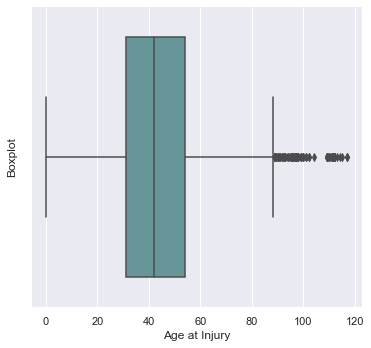

In [155]:
sns.catplot(data=train_df_out, kind='box', x='Age at Injury', color='cadetblue')
plt.xlabel('Age at Injury')
plt.ylabel('Boxplot')

# Outliers after 85 years old

In [161]:
# Total number of rows in the DataFrame
total_rows = len(train_df_out)

# Count rows with 'Age at Injury' below 14
below_14_count = train_df_out[train_df_out['Age at Injury'] < 14].shape[0]
below_14_percentage = (below_14_count / total_rows) * 100

# Count rows with 'Age at Injury' over 90
over_90_count = train_df_out[train_df_out['Age at Injury'] > 90].shape[0]
over_90_percentage = (over_90_count / total_rows) * 100

# Print the results
print(f"Number of rows with 'Age at Injury' below 14: {below_14_count} ({below_14_percentage:.2f}%)")
print(f"Number of rows with 'Age at Injury' over 90: {over_90_count} ({over_90_percentage:.2f}%)")

Number of rows with 'Age at Injury' below 14: 1822 (0.32%)
Number of rows with 'Age at Injury' over 90: 166 (0.03%)


In [160]:
# Drop rows with 'Age at Injury' below 14 or over 90
train_df_out_cleaned = train_df_out[(train_df_out['Age at Injury'] >= 14) & (train_df_out['Age at Injury'] <= 90)]

# Reset the index after dropping rows
train_df_out_cleaned.reset_index(drop=True, inplace=True)

# Print the number of rows in the cleaned DataFrame
print(f"Number of rows after removing outliers: {train_df_out_cleaned.shape[0]}")
print(f"Percentage of the whole training data set: {round(len(train_df_out_cleaned)/len(train_df),2)*100}%")

Number of rows after removing outliers: 568349
Percentage of the whole training data set: 96.0%


To deal with the outliers of "Average Weekly Wage", we will use binning such that the 0 values are one category and the high outliers will be in one category and don't bias the data too much.

### 3.3 Binning and Feature Extraction

__Binning__:
- __Age at Injury__: Bin into 10-year age groups
- __Average Weekly Wage__: Group wages into ranges to handle the wide variance
- __Gender__: Combine "X" and "U" into an "Other" category for non-binary classifications
- __WCIO Cause of Injury Description__: Group similar injury causes together for a consolidated view of cause categories
- __WCIO Nature of Injury Description__: Group similar injury types (e.g., physical trauma, diseases) to capture broader injury classifications
- __WCIO Part Of Body Description__: Combine specific body parts into larger areas (e.g., "Upper Arm" and "Shoulder" into "Upper Arm and Shoulder") to simplify the body region analysis


In [162]:
train_df_bin = train_df_out_cleaned.copy()

In [163]:
# Group "Age at Injury" and "Average Weekly Wage" into Bins

# Define age bins and labels
age_bins = [0, 19, 29, 39, 49, 59, float('inf')]
age_labels = ['Under 20', '20-29', '30-39', '40-49', '50-59', '60 and above']

# Create the age groups
train_df_bin['Age_Group'] = pd.cut(train_df_bin['Age at Injury'], bins=age_bins, labels=age_labels)


# Group Average Weekly Wage into bins
# Define wage bins and labels
wage_bins = [0, 1, 700, 1100, 1500, max(train_df_bin['Average Weekly Wage'])]
wage_labels = ['Zero','Below Average', 'Average', 'Above Average', 'High']

# Create the wage groups
train_df_bin['Wage_Group'] = pd.cut(train_df_bin['Average Weekly Wage'], bins=wage_bins, labels=wage_labels)

In [164]:
# Mapping categorical variables

# Gender: Combine "U" and "X" into "Other"
train_df_bin['Gender'] = train_df_bin['Gender'].replace({'U': 'Other', 'X': 'Other'})


In [165]:
# WCIO Cause of Injury Description
train_df_bin['WCIO Cause of Injury Description'].unique();
train_df_bin['WCIO Cause of Injury Description'].value_counts()

LIFTING                                   59594
FELLOW WORKER, PATIENT OR OTHER PERSON    37094
STRAIN OR INJURY BY, NOC                  32988
FALL, SLIP OR TRIP, NOC                   31677
ON SAME LEVEL                             29307
                                          ...  
MOLD                                         55
ABNORMAL AIR PRESSURE                        51
CRASH OF WATER VEHICLE                       45
RADIATION                                    34
CRASH OF AIRPLANE                            12
Name: WCIO Cause of Injury Description, Length: 74, dtype: int64

In [166]:
# Mapping dictionary
injury_mapping = {
    'FALL, SLIP OR TRIP, NOC': 'Falls and Slips',
    'FROM LIQUID OR GREASE SPILLS': 'Falls and Slips',
    'ON ICE OR SNOW': 'Falls and Slips',
    'ON SAME LEVEL': 'Falls and Slips',
    'ON STAIRS': 'Falls and Slips',
    'SLIP, OR TRIP, DID NOT FALL': 'Falls and Slips',
    
    'OBJECT BEING LIFTED OR HANDLED': 'Lifting and Strain',
    'LIFTING': 'Lifting and Strain',
    'TWISTING': 'Lifting and Strain',
    'PUSHING OR PULLING': 'Lifting and Strain',
    'STRAIN OR INJURY BY, NOC': 'Lifting and Strain',
    'REACHING': 'Lifting and Strain',
    'HOLDING OR CARRYING': 'Lifting and Strain',
    
    'COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE': 'Collisions and Motor Vehicle Accidents',
    'MOTOR VEHICLE, NOC': 'Collisions and Motor Vehicle Accidents',
    'MOTOR VEHICLE': 'Collisions and Motor Vehicle Accidents',
    'COLLISION WITH A FIXED OBJECT': 'Collisions and Motor Vehicle Accidents',
    'CRASH OF RAIL VEHICLE': 'Collisions and Motor Vehicle Accidents',
    'CRASH OF WATER VEHICLE': 'Collisions and Motor Vehicle Accidents',
    'CRASH OF AIRPLANE': 'Collisions and Motor Vehicle Accidents',
    'VEHICLE UPSET': 'Collisions and Motor Vehicle Accidents',
    
    'STRUCK OR INJURED, NOC': 'Struck By Object or Person',
    'FALLING OR FLYING OBJECT': 'Struck By Object or Person',
    'STEPPING ON SHARP OBJECT': 'Struck By Object or Person',
    'FELLOW WORKER, PATIENT OR OTHER PERSON': 'Struck By Object or Person',
    'ANIMAL OR INSECT': 'Struck By Object or Person',
    'WIELDING OR THROWING': 'Struck By Object or Person',
    
    'CHEMICALS': 'Exposure to Substances and Environment',
    'DUST, GASES, FUMES OR VAPORS': 'Exposure to Substances and Environment',
    'ABSORPTION, INGESTION OR INHALATION, NOC': 'Exposure to Substances and Environment',
    'STEAM OR HOT FLUIDS': 'Exposure to Substances and Environment',
    'COLD OBJECTS OR SUBSTANCES': 'Exposure to Substances and Environment',
    'TEMPERATURE EXTREMES': 'Exposure to Substances and Environment',
    'CONTINUAL NOISE': 'Exposure to Substances and Environment',
    'MOLD': 'Exposure to Substances and Environment',
    'ABNORMAL AIR PRESSURE': 'Exposure to Substances and Environment',
    'RADIATION': 'Exposure to Substances and Environment',
    
    'HAND TOOL, UTENSIL; NOT POWERED': 'Tools, Machinery, and Objects',
    'POWERED HAND TOOL, APPLIANCE': 'Tools, Machinery, and Objects',
    'USING TOOL OR MACHINERY': 'Tools, Machinery, and Objects',
    'MOVING PARTS OF MACHINE': 'Tools, Machinery, and Objects',
    'MACHINE OR MACHINERY': 'Tools, Machinery, and Objects',
    'MOVING PART OF MACHINE': 'Tools, Machinery, and Objects',
    'OBJECT HANDLED BY OTHERS': 'Tools, Machinery, and Objects',
    'BROKEN GLASS': 'Tools, Machinery, and Objects',
    
    'FIRE OR FLAME': 'Explosions and Fire',
    'EXPLOSION OR FLARE BACK': 'Explosions and Fire',
    
    'NATURAL DISASTERS': 'Natural Disasters and Uncommon Events',
    'TERRORISM': 'Natural Disasters and Uncommon Events',
    'PANDEMIC': 'Natural Disasters and Uncommon Events',
}

# Apply mapping
train_df_bin['Injury Category'] = train_df_bin['WCIO Cause of Injury Description'].map(injury_mapping).fillna('Other')
print(train_df_bin)

       Accident Date  Age at Injury Alternative Dispute Resolution  \
0         2019-12-30           31.0                              N   
1         2019-08-30           46.0                              N   
2         2019-12-06           40.0                              N   
3         2019-12-30           61.0                              N   
4         2019-12-26           67.0                              N   
...              ...            ...                            ...   
568344    2022-12-14           35.0                              N   
568345    2022-12-15           33.0                              N   
568346    2022-12-13           61.0                              N   
568347    2022-12-14           24.0                              N   
568348    2022-12-13           72.0                              N   

       Assembly Date Attorney/Representative  Average Weekly Wage    C-2 Date  \
0         2020-01-01                       N                 0.00  2019-12-31 

In [167]:
# WCIO Nature of Injury Description
train_df_bin['WCIO Nature of Injury Description'].unique();
train_df_bin['WCIO Nature of Injury Description'].value_counts()

STRAIN OR TEAR                                                 165863
CONTUSION                                                      110483
SPRAIN OR TEAR                                                  55599
LACERATION                                                      47030
ALL OTHER SPECIFIC INJURIES, NOC                                35862
COVID-19                                                        25524
FRACTURE                                                        22639
PUNCTURE                                                        17310
MULTIPLE PHYSICAL INJURIES ONLY                                 12645
INFLAMMATION                                                    12445
BURN                                                             7499
FOREIGN BODY                                                     7363
NO PHYSICAL INJURY                                               5923
DISLOCATION                                                      5858
CONCUSSION          

In [168]:
# Mapping dictionary
injury_nature_mapping = {
    'CONTUSION': 'Physical Trauma',
    'SPRAIN OR TEAR': 'Physical Trauma',
    'CONCUSSION': 'Physical Trauma',
    'PUNCTURE': 'Physical Trauma',
    'LACERATION': 'Physical Trauma',
    'FRACTURE': 'Physical Trauma',
    'CRUSHING': 'Physical Trauma',
    'DISLOCATION': 'Physical Trauma',
    'AMPUTATION': 'Physical Trauma',
    'SEVERANCE': 'Physical Trauma',
    
    'CARPAL TUNNEL SYNDROME': 'Cumulative or Repetitive Injuries',
    'INFLAMMATION': 'Cumulative or Repetitive Injuries',
    'ALL OTHER CUMULATIVE INJURY, NOC': 'Cumulative or Repetitive Injuries',
    'ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC': 'Cumulative or Repetitive Injuries',
    'ALL OTHER SPECIFIC INJURIES, NOC': 'Cumulative or Repetitive Injuries',
    
    'BURN': 'Burns and Temperature-Related Injuries',
    'HEAT PROSTRATION': 'Burns and Temperature-Related Injuries',
    'FREEZING': 'Burns and Temperature-Related Injuries',
    
    'RESPIRATORY DISORDERS': 'Respiratory Issues',
    'ASBESTOSIS': 'Respiratory Issues',
    'DUST DISEASE, NOC': 'Respiratory Issues',
    'BLACK LUNG': 'Respiratory Issues',
    'SILICOSIS': 'Respiratory Issues',
    'BYSSINOSIS': 'Respiratory Issues',
    
    'POISONING - GENERAL (NOT OD OR CUMULATIVE': 'Poisoning and Chemical Exposure',
    'POISONING - CHEMICAL, (OTHER THAN METALS)': 'Poisoning and Chemical Exposure',
    'POISONING - METAL': 'Poisoning and Chemical Exposure',
    
    'INFECTION': 'Infections and Diseases',
    'COVID-19': 'Infections and Diseases',
    'CONTAGIOUS DISEASE': 'Infections and Diseases',
    'AIDS': 'Infections and Diseases',
    'HEPATITIS C': 'Infections and Diseases',
    'CANCER': 'Infections and Diseases',
    
    'MENTAL STRESS': 'Psychological and Mental Health',
    'MENTAL DISORDER': 'Psychological and Mental Health',
    'NO PHYSICAL INJURY': 'Psychological and Mental Health',
    'MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL': 'Psychological and Mental Health',
    
    'MYOCARDIAL INFARCTION': 'Circulatory and Heart-Related Issues',
    'ANGINA PECTORIS': 'Circulatory and Heart-Related Issues',
    'VASCULAR': 'Circulatory and Heart-Related Issues',
    
    'LOSS OF HEARING': 'Sensory Loss',
    'HEARING LOSS OR IMPAIRMENT': 'Sensory Loss',
    'VISION LOSS': 'Sensory Loss',
    'ENUCLEATION': 'Sensory Loss',
    
    'RADIATION': 'Radiation and Light Exposure',
    'VDT - RELATED DISEASES': 'Radiation and Light Exposure',
    
    # Miscellaneous (catch-all for remaining cases)
    'ASPHYXIATION': 'Miscellaneous Conditions',
    'SYNCOPE': 'Miscellaneous Conditions',
    'DERMATITIS': 'Miscellaneous Conditions',
    'ADVERSE REACTION TO A VACCINATION OR INOCULATION': 'Miscellaneous Conditions'
}

# Apply mapping
train_df_bin['Injury Category'] = train_df_bin['WCIO Nature of Injury Description'].map(injury_nature_mapping).fillna('Other')


In [169]:
# WCIO Part Of Body Description
train_df_bin['WCIO Part Of Body Description'].unique();
train_df_bin['WCIO Part Of Body Description'].value_counts()

LOWER BACK AREA                                          65837
KNEE                                                     47785
MULTIPLE                                                 41836
SHOULDER(S)                                              37672
FINGER(S)                                                36044
HAND                                                     31197
ANKLE                                                    24909
MULTIPLE BODY PARTS (INCLUDING BODY                      22416
SOFT TISSUE                                              19646
FOOT                                                     18725
WRIST                                                    18625
LOWER ARM                                                15322
LUNGS                                                    13869
EYE(S)                                                   12938
THUMB                                                    12507
LOWER LEG                                              

In [170]:
# Mapping dictionary
body_part_mapping = {
    # Head and Face
    'SKULL': 'Head and Face', 'FACIAL BONES': 'Head and Face', 'EYE(S)': 'Head and Face',
    'MOUTH': 'Head and Face', 'NOSE': 'Head and Face', 'EAR(S)': 'Head and Face', 
    'BRAIN': 'Head and Face', 'TEETH': 'Head and Face',

    # Neck and Throat
    'MULTIPLE NECK INJURY': 'Neck and Throat', 'LARYNX': 'Neck and Throat', 'TRACHEA': 'Neck and Throat',

    # Upper and Lower Back
    'UPPER BACK AREA': 'Upper Back',
    'LOWER BACK AREA': 'Lower Back', 'LUMBAR & OR SACRAL VERTEBRAE (VERTEBRA': 'Lower Back',
    'SACRUM AND COCCYX': 'Lower Back',

    # Spinal Column
    'SPINAL CORD': 'Spinal Column', 'VERTEBRAE': 'Spinal Column',

    # Shoulder
    'SHOULDER(S)': 'Shoulder', 

    # Arm and Wrist
    'LOWER ARM': 'Arm and Wrist', 'UPPER ARM': 'Arm and Wrist', 'WRIST': 'Arm and Wrist',

    # Hand and Fingers
    'HAND': 'Hand and Fingers', 'FINGER(S)': 'Hand and Fingers', 'THUMB': 'Hand and Fingers',

    # Hip
    'HIP': 'Hip', 

    # Leg
    'LOWER LEG': 'Leg', 'UPPER LEG': 'Leg',

    # Lower Leg and Knee
    'KNEE': 'Knee',

    # Ankle and Foot
    'ANKLE': 'Ankle and Foot', 'FOOT': 'Ankle and Foot', 'TOES': 'Ankle and Foot', 'GREAT TOE': 'Ankle and Foot',

    # Chest
    'CHEST': 'Chest',

    # Abdomen and Pelvis
    'ABDOMEN INCLUDING GROIN': 'Abdomen and Pelvis', 'PELVIS': 'Abdomen and Pelvis', 'BUTTOCKS': 'Abdomen and Pelvis',

    # Lungs
    'LUNGS': 'Lungs',

    # Heart
    'HEART': 'Heart',

    # Internal Organs
    'INTERNAL ORGANS': 'Internal Organs',

    # Body Systems
    'BODY SYSTEMS AND MULTIPLE BODY SYSTEMS': 'Body Systems', 
    'WHOLE BODY': 'Body Systems', 'MULTIPLE BODY PARTS (INCLUDING BODY': 'Body Systems',
    'ARTIFICIAL APPLIANCE': 'Body Systems',

    # Soft Tissue
    'SOFT TISSUE': 'Soft Tissue',

    # Unclassified or Insufficient Info
    'NO PHYSICAL INJURY': 'Unclassified or Insufficient Info',
    'INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED': 'Unclassified or Insufficient Info'
}

# Apply mapping
train_df_bin['Body Part Category'] = train_df_bin['WCIO Part Of Body Description'].map(body_part_mapping).fillna('Other')


__Feature Extraction:__
- __Lag_Time__: Difference in days between accident date and assembly date
- __Accident_to_C2_Lag__: Difference in days between accident date and C-2 date

In [172]:
# Convert columns to datetime format and handle errors
train_df_date2 = train_df_bin.copy()
train_df_date2['Accident Date'] = pd.to_datetime(train_df_date2['Accident Date'], errors='coerce')
train_df_date2['Assembly Date'] = pd.to_datetime(train_df_date2['Assembly Date'], errors='coerce')
train_df_date2['C-2 Date'] = pd.to_datetime(train_df_date2['C-2 Date'], errors='coerce')

# Check for any correlation between date columns by converting them to numeric values (days since start)
train_df_date2['Lag_Time'] = (train_df_date2['Assembly Date'] - train_df_date2['Accident Date'].min()).dt.days
train_df_date2['Accident_to_C2_Lag'] = (train_df_date2['C-2 Date'] - train_df_date2['Accident Date'].min()).dt.days

# Correlation matrix for date columns
correlation_matrix_date = train_df_date2[['Lag_Time', 'Accident_to_C2_Lag']].corr()
correlation_matrix_date

,Lag_Time,Accident_to_C2_Lag
Lag_Time,1.000000,0.088743
Accident_to_C2_Lag,0.088743,1.000000


In [175]:
train_df_bin['Lag_Time'] = train_df_date2['Lag_Time']
train_df_bin['Accident_to_C2_Lag'] = train_df_date2['Accident_to_C2_Lag']

### 3.4 Data Scaling

## 4. Feature Selection <a id='features'></a>
[to the top](#top)

_"Define and implement an unambiguous strategy for feature selection. Use methods discussed in the course. Present and justify your final selection."_

## 5. Modeling and Evaluation <a id='modeling'></a>
[to the top](#top)

- _"Identify the type of the problem and select the relevant algorithms._
- _Use cross-validation to assess performance. Which metrics did you use and why?_
- _Train at least 1 model using the train dataset and obtain predictions for the test dataset."_

In [ ]:
# test